### training a denoising autoencoder for CIFAR10 dataset

Load & Normalize CIFAR-10 Data

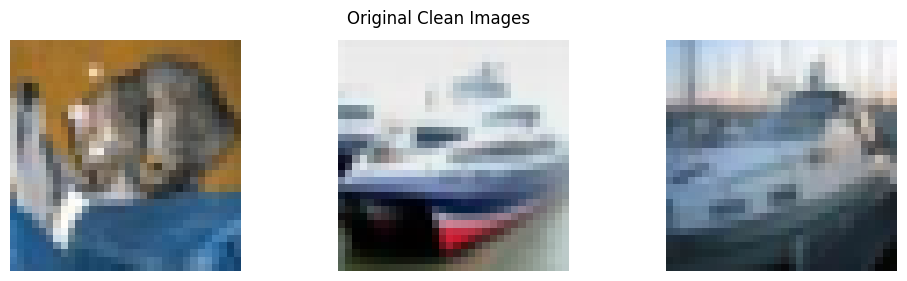

In [47]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

(x_train, _), (x_test, _) = tf.keras.datasets.cifar10.load_data()
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

plt.figure(figsize=(12, 3))
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.imshow(x_test[i])
    plt.axis('off')
plt.suptitle("Original Clean Images")
plt.show()


Add Gaussian Noise

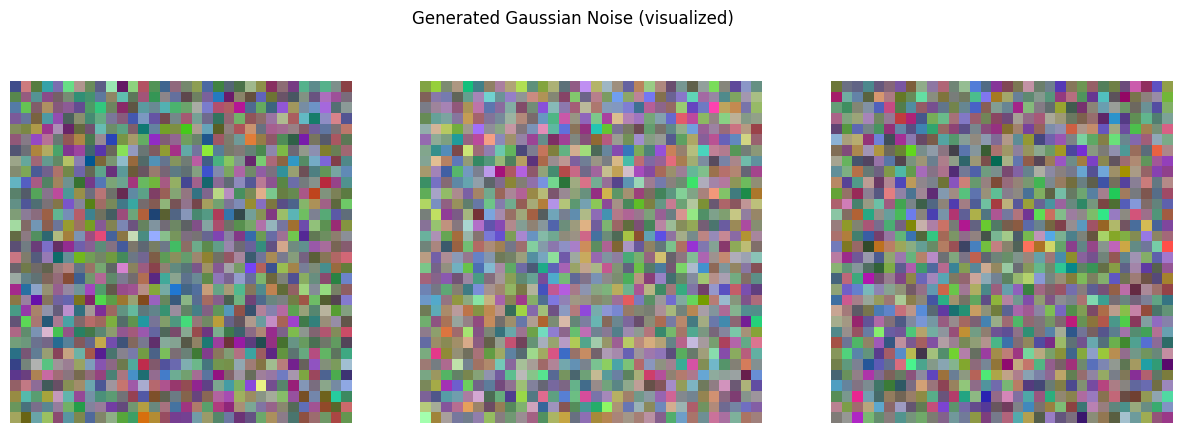

In [48]:
noise_factor = 0.3

noise_train = noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
noise_test = noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

plt.figure(figsize=(15, 5))
for i in range(3):
    plt.subplot(1, 3, i+1)
    noise_img = noise_test[i]
    noise_img = (noise_img - noise_img.min()) / (noise_img.max() - noise_img.min())
    plt.imshow(noise_img)
    plt.axis('off')
plt.suptitle("Generated Gaussian Noise (visualized)")
plt.show()




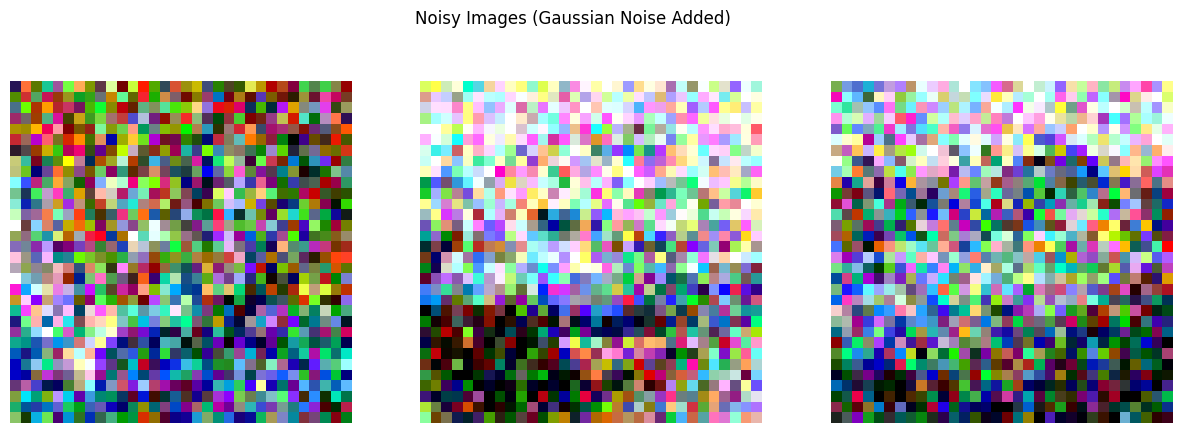

In [49]:
x_train_noisy = x_train + noise_train
x_test_noisy = x_test + noise_test
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

plt.figure(figsize=(15, 5))
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.imshow(x_test_noisy[i])
    plt.axis('off')
plt.suptitle("Noisy Images (Gaussian Noise Added)")
plt.show()

Build the Denoising Autoencoder

In [50]:
import tensorflow as tf
from tensorflow.keras import layers, models, losses

encoder = models.Sequential([
    layers.Input(shape=(32, 32, 3)),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(2, name="latent_vector")  # 2D bottleneck
])


decoder = models.Sequential([
    layers.Input(shape=(2,)),
    layers.Dense(64, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(512, activation='relu'),
    layers.Dense(32*32*3, activation='sigmoid'),
    layers.Reshape((32, 32, 3))
])

autoencoder = models.Sequential([encoder, decoder])

# Compile with Adam optimizer and MSE loss
autoencoder.compile(
    optimizer='adam',
    loss='mse',  # Mean Squared Error for image reconstruction
    metrics=['accuracy']  # Optional (not typically used for autoencoders)
)

autoencoder.summary()

Model: "sequential_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_27 (Sequential)      │ (None, 2)              │     1,647,426 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_28 (Sequential)      │ (None, 32, 32, 3)      │     1,650,496 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,297,922 (12.58 MB)

 Trainable params: 3,297,922 (12.58 MB)

 Non-trainable params: 0 (0.00 B)

Train the Autoencoder on Noisy → Clean

In [51]:
autoencoder.fit(x_train_noisy, x_train, epochs=50, batch_size=256, validation_split=0.1)


Epoch 1/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.4294 - loss: 0.0529 - val_accuracy: 0.4774 - val_loss: 0.0374
Epoch 2/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.4816 - loss: 0.0377 - val_accuracy: 0.4802 - val_loss: 0.0368
Epoch 3/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.4877 - loss: 0.0372 - val_accuracy: 0.4843 - val_loss: 0.0366
Epoch 4/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.4951 - loss: 0.0371 - val_accuracy: 0.5067 - val_loss: 0.0364
Epoch 5/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.5017 - loss: 0.0368 - val_accuracy: 0.5121 - val_loss: 0.0362
Epoch 6/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.5139 - loss: 0.0366 - val_accuracy: 0.4985 - val_loss: 0.0359
Epoch 7/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5150 - loss: 0.0360 - val_accuracy: 0.5047 - val_loss: 0.0353
Epoch 8/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5099 - loss: 0.0358 - val_accu

Visualize Denoising Results

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step


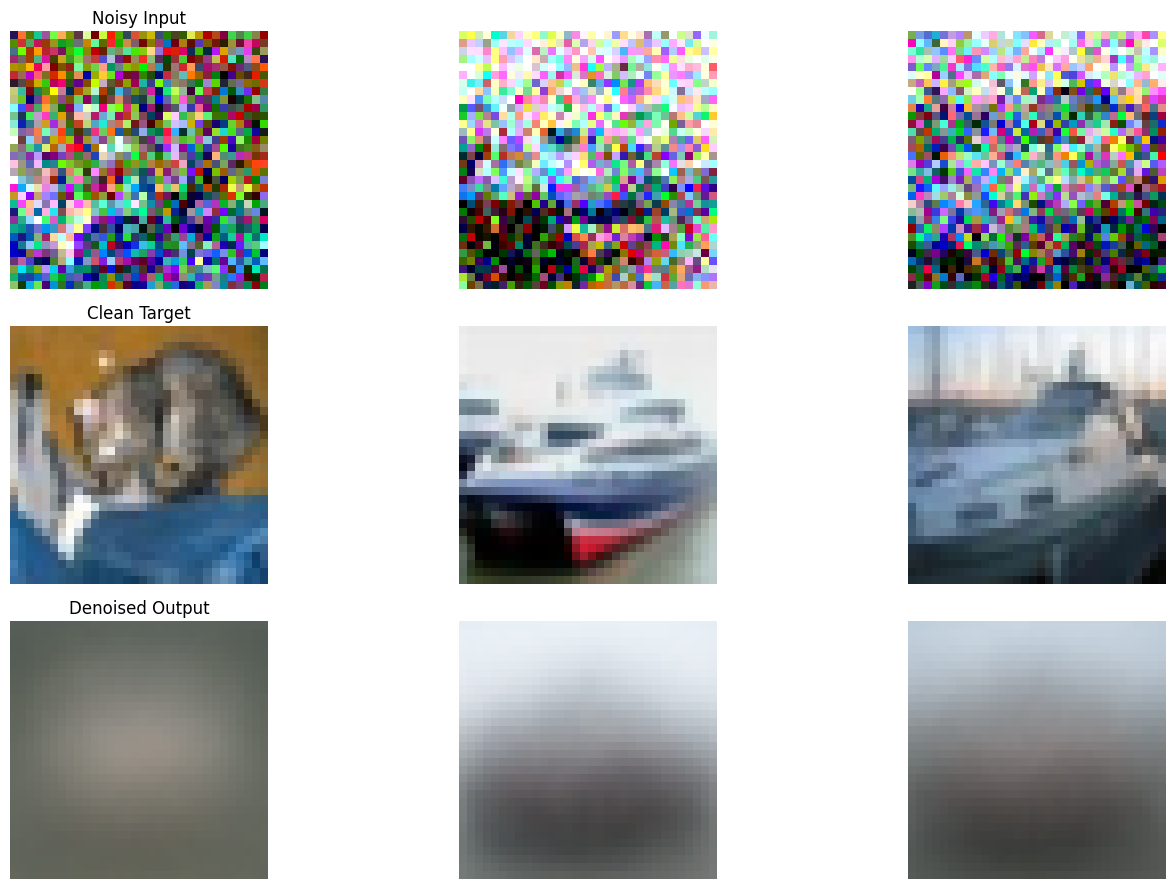

In [52]:
import matplotlib.pyplot as plt

decoded_imgs = autoencoder.predict(x_test_noisy[:10])
n = 3

plt.figure(figsize=(15, 9))  # bigger height for 3 rows

for i in range(n):
    # Noisy Input (Row 1)
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test_noisy[i])
    plt.axis("off")
    if i == 0:
        ax.set_title("Noisy Input")

    # Clean Target (Row 2)
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(x_test[i])
    plt.axis("off")
    if i == 0:
        ax.set_title("Clean Target")

    # Denoised Output (Row 3)
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(decoded_imgs[i])
    plt.axis("off")
    if i == 0:
        ax.set_title("Denoised Output")

plt.tight_layout()
plt.show()
